In [1]:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
    
import os, glob
import sys
import json
import datetime
import numpy as np
import skimage.draw
import shutil
import tensorflow as tf
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize as vis
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt

############################################################
#  Configurations
############################################################

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    # Give the configuration a recognizable name
    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256)


############################################################
#  Dataset
############################################################

class GenericDataset(utils.Dataset):

    def load_item(self, dataset_dir, subset):
        """Load a subset of dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys


       # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        from PIL import Image
        # Add images
        classes = []

        # Find all images in the given dataset directory and load their annotations
        all_files = dict()
        for _ in os.listdir(dataset_dir):
            all_files[".".join(_.split(".")[:-1])] = _ 
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons=[]
            objects=[]
            for r in a['regions']:
                polygons.append(r['shape_attributes'])
                objects.append(r['region_attributes'])

            class_ids = [int(n['class']) for n in objects]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            # print("multi_numbers=", multi_numbers)
            # num_ids = [n for n in multi_numbers['number'].values()]
            # for n in multi_numbers:
            image_path = dataset_dir + "/" + all_files[a['filename'] ]

            image = Image.open(image_path)
            width, height = image.size

            self.add_image(
                "class",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)

            for r in a['regions']:

                _class = r['region_attributes']['class']
                if _class not in classes:
                    classes += [_class]

        for i in range(len(classes)):
            self.add_class("class", i+1,  str(_class))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1



        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #class_ids=np.array([self.class_names.index(shapes[0])])
        #print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids#[mask.shape[-1]] #np.ones([mask.shape[-1]], dtype=np.int32)#class_ids.astype(np.int32)




Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



In [2]:
"""Build Dataset."""
print("Loading Training Dataset...")
DATASET_DIR = "/media/sohaib/additional_/maskrcnn2_0/images/train/"

# Training dataset.
dataset_train = GenericDataset()
dataset_train.load_item(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
print("Loading Validation Dataset...")
dataset_val = GenericDataset()
dataset_val.load_item(DATASET_DIR, "val")
dataset_val.prepare()

Loading Training Dataset...
Loading Validation Dataset...


# Visualizing Dataset

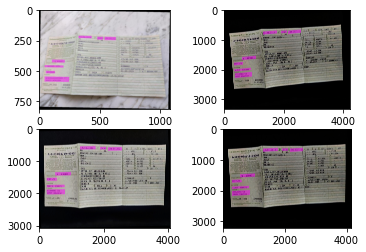

In [3]:
import random

count = 0
rows, cols      = 2, 2
class_ids = list(dataset_val.class_ids)
ids_list  = random.sample(class_ids[0:500], rows * cols)

for id_ in ids_list: 
    count += 1
    id_ -= 1
    
    image = dataset_val.load_image(id_)
    mask, class_id= dataset_val.load_mask(id_)
    _, _, masks_num = mask.shape
    # Ploting Masks
    for i in range(masks_num):
        mask_ = vis.apply_mask(image, mask[:,:,i], [1,2,3])
    
    plt.subplot(rows, cols, count)
    plt.imshow(mask_)
plt.show()

In [4]:
from mrcnn.config import Config
WEIGHTS_DIR = "/media/sohaib/additional_/maskrcnn/weights/"

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes + 1
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    # Give the configuration a recognizable name
    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10
#     RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)


config = GenericConfig(7, 100)


model = modellib.MaskRCNN(mode="training", config=config, model_dir=WEIGHTS_DIR)
                



Initilizing Config


In [ ]:


transfer_weights_path = "/media/sohaib/additional_/maskrcnn/weights/448_class20210419T0158/mask_rcnn_448_class_0171.h5"
model.load_weights(transfer_weights_path, by_name=False, exclude=None)

model.train(dataset_train, dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=1000,
        layers='all')

Re-starting from epoch 171

Starting at epoch 171. LR=0.001

Checkpoint Path: /media/sohaib/additional_/maskrcnn/weights/448_class20210419T0158/mask_rcnn_448_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (Ba

/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), va

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.4562 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1428WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 55s 375ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4562 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1428 - val_loss: 1.1581 - val_rpn_class_loss: 0.0280 - val_rpn_bbox_loss: 0.3017 - val_mrcnn_class_loss: 0.2046 - val_mrcnn_bbox_loss: 0.2948 - val_mrcnn_mask_loss: 0.3290
Epoch 173/1000
100/100 [==============================] - 28s 280ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3950 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1358 - val_loss: 1.4584 - val_rpn_class_loss: 0.0417 - val_rpn_bbox_loss: 0.3510 - val_mrcnn_class_loss: 0.3651 - val_mrcnn_bbox_loss: 0.3079 - val_mrcnn_mask_loss: 0.3927
Epoch 174/1000
100/100 [==============================] - 31s 310ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4340 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0855 - mrcnn_class_lo

Epoch 183/1000
100/100 [==============================] - 26s 262ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4648 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1563 - val_loss: 1.2335 - val_rpn_class_loss: 0.0343 - val_rpn_bbox_loss: 0.3218 - val_mrcnn_class_loss: 0.2403 - val_mrcnn_bbox_loss: 0.2737 - val_mrcnn_mask_loss: 0.3634
Epoch 184/1000
100/100 [==============================] - 30s 304ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5202 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1263 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1623 - val_loss: 1.4178 - val_rpn_class_loss: 0.0539 - val_rpn_bbox_loss: 0.3856 - val_mrcnn_class_loss: 0.3379 - val_mrcnn_bbox_loss: 0.2701 - val_mrcnn_mask_loss: 0.3703
Epoch 185/1000
100/100 [==============================] - 27s 272ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5224 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1321 -

100/100 [==============================] - 32s 323ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4822 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1745 - val_loss: 1.0554 - val_rpn_class_loss: 0.0329 - val_rpn_bbox_loss: 0.3193 - val_mrcnn_class_loss: 0.1791 - val_mrcnn_bbox_loss: 0.2453 - val_mrcnn_mask_loss: 0.2788
Epoch 194/1000
100/100 [==============================] - 29s 290ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4578 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1647 - val_loss: 1.2205 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 0.3603 - val_mrcnn_class_loss: 0.1902 - val_mrcnn_bbox_loss: 0.3082 - val_mrcnn_mask_loss: 0.3313
Epoch 195/1000
100/100 [==============================] - 25s 250ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.5286 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1174 - mrcnn_class_lo

100/100 [==============================] - 30s 298ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4206 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1471 - val_loss: 1.2106 - val_rpn_class_loss: 0.0248 - val_rpn_bbox_loss: 0.3112 - val_mrcnn_class_loss: 0.2511 - val_mrcnn_bbox_loss: 0.2934 - val_mrcnn_mask_loss: 0.3301
Epoch 204/1000
100/100 [==============================] - 30s 303ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4111 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1412 - val_loss: 1.2479 - val_rpn_class_loss: 0.0425 - val_rpn_bbox_loss: 0.3351 - val_mrcnn_class_loss: 0.2513 - val_mrcnn_bbox_loss: 0.2820 - val_mrcnn_mask_loss: 0.3370
Epoch 205/1000
100/100 [==============================] - 31s 314ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3709 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0840 - mrcnn_class_lo

100/100 [==============================] - 29s 290ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4482 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1424 - val_loss: 1.3494 - val_rpn_class_loss: 0.0476 - val_rpn_bbox_loss: 0.3545 - val_mrcnn_class_loss: 0.2401 - val_mrcnn_bbox_loss: 0.3048 - val_mrcnn_mask_loss: 0.4023
Epoch 214/1000
100/100 [==============================] - 30s 302ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3809 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1374 - val_loss: 1.3370 - val_rpn_class_loss: 0.0642 - val_rpn_bbox_loss: 0.3405 - val_mrcnn_class_loss: 0.2753 - val_mrcnn_bbox_loss: 0.3048 - val_mrcnn_mask_loss: 0.3523
Epoch 215/1000
100/100 [==============================] - 25s 254ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4342 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1085 - mrcnn_class_lo

100/100 [==============================] - 34s 343ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3353 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1182 - val_loss: 1.0936 - val_rpn_class_loss: 0.0269 - val_rpn_bbox_loss: 0.3063 - val_mrcnn_class_loss: 0.1540 - val_mrcnn_bbox_loss: 0.2745 - val_mrcnn_mask_loss: 0.3318
Epoch 224/1000
100/100 [==============================] - 32s 324ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4113 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1303 - val_loss: 1.0896 - val_rpn_class_loss: 0.0437 - val_rpn_bbox_loss: 0.3440 - val_mrcnn_class_loss: 0.1766 - val_mrcnn_bbox_loss: 0.2163 - val_mrcnn_mask_loss: 0.3090
Epoch 225/1000
100/100 [==============================] - 29s 289ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4625 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1076 - mrcnn_class_lo

100/100 [==============================] - 29s 293ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3664 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1280 - val_loss: 1.3452 - val_rpn_class_loss: 0.0431 - val_rpn_bbox_loss: 0.3941 - val_mrcnn_class_loss: 0.2303 - val_mrcnn_bbox_loss: 0.2871 - val_mrcnn_mask_loss: 0.3906
Epoch 234/1000
100/100 [==============================] - 29s 293ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3575 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1249 - val_loss: 1.2748 - val_rpn_class_loss: 0.0611 - val_rpn_bbox_loss: 0.3811 - val_mrcnn_class_loss: 0.2420 - val_mrcnn_bbox_loss: 0.2690 - val_mrcnn_mask_loss: 0.3216
Epoch 235/1000
100/100 [==============================] - 25s 252ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4087 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0921 - mrcnn_class_lo

100/100 [==============================] - 29s 292ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3669 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1376 - val_loss: 1.1164 - val_rpn_class_loss: 0.0279 - val_rpn_bbox_loss: 0.3449 - val_mrcnn_class_loss: 0.1436 - val_mrcnn_bbox_loss: 0.2653 - val_mrcnn_mask_loss: 0.3346
Epoch 244/1000
100/100 [==============================] - 29s 291ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4046 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1391 - val_loss: 1.1341 - val_rpn_class_loss: 0.0361 - val_rpn_bbox_loss: 0.3075 - val_mrcnn_class_loss: 0.1653 - val_mrcnn_bbox_loss: 0.2933 - val_mrcnn_mask_loss: 0.3319
Epoch 245/1000
100/100 [==============================] - 30s 299ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3967 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0947 - mrcnn_class_lo

100/100 [==============================] - 33s 331ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3595 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1250 - val_loss: 1.0836 - val_rpn_class_loss: 0.0349 - val_rpn_bbox_loss: 0.2768 - val_mrcnn_class_loss: 0.1622 - val_mrcnn_bbox_loss: 0.2608 - val_mrcnn_mask_loss: 0.3489
Epoch 254/1000
100/100 [==============================] - 32s 316ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3692 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1344 - val_loss: 1.0331 - val_rpn_class_loss: 0.0401 - val_rpn_bbox_loss: 0.3086 - val_mrcnn_class_loss: 0.1250 - val_mrcnn_bbox_loss: 0.2538 - val_mrcnn_mask_loss: 0.3055
Epoch 255/1000
100/100 [==============================] - 33s 331ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3739 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0864 - mrcnn_class_lo

100/100 [==============================] - 29s 292ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.4180 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1324 - val_loss: 1.1572 - val_rpn_class_loss: 0.0448 - val_rpn_bbox_loss: 0.3518 - val_mrcnn_class_loss: 0.1825 - val_mrcnn_bbox_loss: 0.2627 - val_mrcnn_mask_loss: 0.3154
Epoch 264/1000
100/100 [==============================] - 31s 311ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3859 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1260 - val_loss: 1.0551 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.3166 - val_mrcnn_class_loss: 0.1863 - val_mrcnn_bbox_loss: 0.2330 - val_mrcnn_mask_loss: 0.2866
Epoch 265/1000
100/100 [==============================] - 29s 294ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3268 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0752 - mrcnn_class_lo

Epoch 273/1000
100/100 [==============================] - 34s 340ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3851 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1481 - val_loss: 1.1054 - val_rpn_class_loss: 0.0252 - val_rpn_bbox_loss: 0.3088 - val_mrcnn_class_loss: 0.1625 - val_mrcnn_bbox_loss: 0.2629 - val_mrcnn_mask_loss: 0.3460
Epoch 274/1000
100/100 [==============================] - 27s 268ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3081 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1160 - val_loss: 1.2366 - val_rpn_class_loss: 0.0368 - val_rpn_bbox_loss: 0.3053 - val_mrcnn_class_loss: 0.2625 - val_mrcnn_bbox_loss: 0.2848 - val_mrcnn_mask_loss: 0.3471
Epoch 275/1000
100/100 [==============================] - 31s 314ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3184 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0856 -

100/100 [==============================] - 29s 288ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3099 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1119 - val_loss: 1.2298 - val_rpn_class_loss: 0.0301 - val_rpn_bbox_loss: 0.3211 - val_mrcnn_class_loss: 0.1952 - val_mrcnn_bbox_loss: 0.2510 - val_mrcnn_mask_loss: 0.4323
Epoch 284/1000
100/100 [==============================] - 25s 254ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2976 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1122 - val_loss: 1.1139 - val_rpn_class_loss: 0.0199 - val_rpn_bbox_loss: 0.2964 - val_mrcnn_class_loss: 0.2032 - val_mrcnn_bbox_loss: 0.2596 - val_mrcnn_mask_loss: 0.3349
Epoch 285/1000
100/100 [==============================] - 28s 276ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3288 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0747 - mrcnn_class_lo

100/100 [==============================] - 26s 260ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3459 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1337 - val_loss: 1.0353 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 0.3061 - val_mrcnn_class_loss: 0.1485 - val_mrcnn_bbox_loss: 0.2652 - val_mrcnn_mask_loss: 0.2822
Epoch 294/1000
100/100 [==============================] - 28s 277ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3421 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1327 - val_loss: 1.1314 - val_rpn_class_loss: 0.0355 - val_rpn_bbox_loss: 0.3258 - val_mrcnn_class_loss: 0.1924 - val_mrcnn_bbox_loss: 0.2443 - val_mrcnn_mask_loss: 0.3334
Epoch 295/1000
100/100 [==============================] - 29s 291ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3372 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0868 - mrcnn_class_lo

100/100 [==============================] - 32s 321ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2872 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1048 - val_loss: 1.2483 - val_rpn_class_loss: 0.0416 - val_rpn_bbox_loss: 0.3289 - val_mrcnn_class_loss: 0.2782 - val_mrcnn_bbox_loss: 0.2641 - val_mrcnn_mask_loss: 0.3356
Epoch 304/1000
100/100 [==============================] - 34s 343ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2555 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0993 - val_loss: 1.2143 - val_rpn_class_loss: 0.0454 - val_rpn_bbox_loss: 0.3201 - val_mrcnn_class_loss: 0.2447 - val_mrcnn_bbox_loss: 0.2633 - val_mrcnn_mask_loss: 0.3408
Epoch 305/1000
100/100 [==============================] - 32s 316ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2661 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0594 - mrcnn_class_lo

100/100 [==============================] - 28s 275ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2944 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1055 - val_loss: 0.9845 - val_rpn_class_loss: 0.0349 - val_rpn_bbox_loss: 0.3007 - val_mrcnn_class_loss: 0.1440 - val_mrcnn_bbox_loss: 0.2068 - val_mrcnn_mask_loss: 0.2981
Epoch 314/1000
100/100 [==============================] - 34s 340ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2820 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1042 - val_loss: 0.9780 - val_rpn_class_loss: 0.0335 - val_rpn_bbox_loss: 0.3218 - val_mrcnn_class_loss: 0.1251 - val_mrcnn_bbox_loss: 0.2107 - val_mrcnn_mask_loss: 0.2869
Epoch 315/1000
100/100 [==============================] - 31s 310ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2822 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0667 - mrcnn_class_lo

100/100 [==============================] - 31s 307ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2611 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.0970 - val_loss: 1.1951 - val_rpn_class_loss: 0.0185 - val_rpn_bbox_loss: 0.3104 - val_mrcnn_class_loss: 0.1913 - val_mrcnn_bbox_loss: 0.2999 - val_mrcnn_mask_loss: 0.3750
Epoch 324/1000
100/100 [==============================] - 34s 342ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3445 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1128 - val_loss: 1.1675 - val_rpn_class_loss: 0.0248 - val_rpn_bbox_loss: 0.3402 - val_mrcnn_class_loss: 0.1895 - val_mrcnn_bbox_loss: 0.2930 - val_mrcnn_mask_loss: 0.3200
Epoch 325/1000
100/100 [==============================] - 33s 334ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2425 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0604 - mrcnn_class_lo

100/100 [==============================] - 26s 260ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2570 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0984 - val_loss: 1.2482 - val_rpn_class_loss: 0.0492 - val_rpn_bbox_loss: 0.3295 - val_mrcnn_class_loss: 0.2375 - val_mrcnn_bbox_loss: 0.2859 - val_mrcnn_mask_loss: 0.3461
Epoch 334/1000
100/100 [==============================] - 30s 295ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2731 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1040 - val_loss: 1.1762 - val_rpn_class_loss: 0.0459 - val_rpn_bbox_loss: 0.2816 - val_mrcnn_class_loss: 0.2510 - val_mrcnn_bbox_loss: 0.2328 - val_mrcnn_mask_loss: 0.3649
Epoch 335/1000
100/100 [==============================] - 30s 302ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3162 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0695 - mrcnn_class_lo

100/100 [==============================] - 31s 314ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2831 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.1084 - val_loss: 1.0693 - val_rpn_class_loss: 0.0289 - val_rpn_bbox_loss: 0.2796 - val_mrcnn_class_loss: 0.2125 - val_mrcnn_bbox_loss: 0.2096 - val_mrcnn_mask_loss: 0.3386
Epoch 344/1000
100/100 [==============================] - 30s 296ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2726 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1049 - val_loss: 1.0147 - val_rpn_class_loss: 0.0472 - val_rpn_bbox_loss: 0.3054 - val_mrcnn_class_loss: 0.1922 - val_mrcnn_bbox_loss: 0.1856 - val_mrcnn_mask_loss: 0.2843
Epoch 345/1000
100/100 [==============================] - 28s 276ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3207 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0798 - mrcnn_class_lo

100/100 [==============================] - 35s 353ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2282 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0858 - val_loss: 1.1264 - val_rpn_class_loss: 0.0429 - val_rpn_bbox_loss: 0.2897 - val_mrcnn_class_loss: 0.2480 - val_mrcnn_bbox_loss: 0.2157 - val_mrcnn_mask_loss: 0.3301
Epoch 354/1000
100/100 [==============================] - 30s 305ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2103 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0816 - val_loss: 1.0816 - val_rpn_class_loss: 0.0270 - val_rpn_bbox_loss: 0.2610 - val_mrcnn_class_loss: 0.2181 - val_mrcnn_bbox_loss: 0.2343 - val_mrcnn_mask_loss: 0.3411
Epoch 355/1000
100/100 [==============================] - 29s 296ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2456 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0566 - mrcnn_class_lo

100/100 [==============================] - 30s 298ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2683 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1008 - val_loss: 0.9640 - val_rpn_class_loss: 0.0310 - val_rpn_bbox_loss: 0.2761 - val_mrcnn_class_loss: 0.1714 - val_mrcnn_bbox_loss: 0.1955 - val_mrcnn_mask_loss: 0.2900
Epoch 364/1000
100/100 [==============================] - 24s 235ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2890 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1029 - val_loss: 1.0009 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.2713 - val_mrcnn_class_loss: 0.1707 - val_mrcnn_bbox_loss: 0.2144 - val_mrcnn_mask_loss: 0.3159
Epoch 365/1000
100/100 [==============================] - 25s 252ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.3135 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0781 - mrcnn_class_lo

Epoch 373/1000
100/100 [==============================] - 31s 315ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2378 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0884 - val_loss: 1.1312 - val_rpn_class_loss: 0.0301 - val_rpn_bbox_loss: 0.2814 - val_mrcnn_class_loss: 0.2263 - val_mrcnn_bbox_loss: 0.2328 - val_mrcnn_mask_loss: 0.3607
Epoch 374/1000
100/100 [==============================] - 31s 307ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2308 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0969 - val_loss: 1.1035 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.3238 - val_mrcnn_class_loss: 0.1693 - val_mrcnn_bbox_loss: 0.2404 - val_mrcnn_mask_loss: 0.3392
Epoch 375/1000
100/100 [==============================] - 30s 296ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2426 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0493 -

100/100 [==============================] - 34s 340ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1866 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0710 - val_loss: 1.0843 - val_rpn_class_loss: 0.0422 - val_rpn_bbox_loss: 0.2895 - val_mrcnn_class_loss: 0.1879 - val_mrcnn_bbox_loss: 0.1978 - val_mrcnn_mask_loss: 0.3669
Epoch 384/1000
100/100 [==============================] - 30s 304ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1770 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0806 - val_loss: 1.0565 - val_rpn_class_loss: 0.0424 - val_rpn_bbox_loss: 0.2714 - val_mrcnn_class_loss: 0.1807 - val_mrcnn_bbox_loss: 0.2131 - val_mrcnn_mask_loss: 0.3488
Epoch 385/1000
100/100 [==============================] - 29s 289ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1838 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0354 - mrcnn_class_lo

100/100 [==============================] - 30s 305ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2193 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0867 - val_loss: 0.9142 - val_rpn_class_loss: 0.0284 - val_rpn_bbox_loss: 0.2687 - val_mrcnn_class_loss: 0.1450 - val_mrcnn_bbox_loss: 0.1737 - val_mrcnn_mask_loss: 0.2985
Epoch 394/1000
100/100 [==============================] - 34s 339ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1789 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0705 - val_loss: 0.9754 - val_rpn_class_loss: 0.0281 - val_rpn_bbox_loss: 0.2586 - val_mrcnn_class_loss: 0.2367 - val_mrcnn_bbox_loss: 0.1759 - val_mrcnn_mask_loss: 0.2760
Epoch 395/1000
100/100 [==============================] - 32s 325ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1743 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0334 - mrcnn_class_lo

100/100 [==============================] - 30s 298ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1755 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0668 - val_loss: 0.9925 - val_rpn_class_loss: 0.0375 - val_rpn_bbox_loss: 0.2699 - val_mrcnn_class_loss: 0.1736 - val_mrcnn_bbox_loss: 0.2276 - val_mrcnn_mask_loss: 0.2838
Epoch 404/1000
100/100 [==============================] - 31s 306ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1935 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0731 - val_loss: 0.8825 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 0.2641 - val_mrcnn_class_loss: 0.1047 - val_mrcnn_bbox_loss: 0.2147 - val_mrcnn_mask_loss: 0.2808
Epoch 405/1000
100/100 [==============================] - 32s 316ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1704 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0413 - mrcnn_class_lo

100/100 [==============================] - 30s 297ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1854 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0692 - val_loss: 1.0369 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 0.2635 - val_mrcnn_class_loss: 0.1607 - val_mrcnn_bbox_loss: 0.2399 - val_mrcnn_mask_loss: 0.3478
Epoch 414/1000
100/100 [==============================] - 29s 291ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2453 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0921 - val_loss: 1.1989 - val_rpn_class_loss: 0.0626 - val_rpn_bbox_loss: 0.2942 - val_mrcnn_class_loss: 0.2624 - val_mrcnn_bbox_loss: 0.2211 - val_mrcnn_mask_loss: 0.3587
Epoch 415/1000
100/100 [==============================] - 31s 313ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2084 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0464 - mrcnn_class_lo

100/100 [==============================] - 30s 299ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1926 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0716 - val_loss: 1.2199 - val_rpn_class_loss: 0.0300 - val_rpn_bbox_loss: 0.2537 - val_mrcnn_class_loss: 0.2360 - val_mrcnn_bbox_loss: 0.2492 - val_mrcnn_mask_loss: 0.4509
Epoch 424/1000
100/100 [==============================] - 31s 307ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1875 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0729 - val_loss: 1.0887 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 0.2551 - val_mrcnn_class_loss: 0.1887 - val_mrcnn_bbox_loss: 0.2366 - val_mrcnn_mask_loss: 0.3797
Epoch 425/1000
100/100 [==============================] - 25s 250ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2665 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0574 - mrcnn_class_lo

100/100 [==============================] - 28s 277ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1787 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0699 - val_loss: 1.0798 - val_rpn_class_loss: 0.0332 - val_rpn_bbox_loss: 0.2623 - val_mrcnn_class_loss: 0.2172 - val_mrcnn_bbox_loss: 0.2107 - val_mrcnn_mask_loss: 0.3564
Epoch 434/1000
100/100 [==============================] - 27s 273ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1578 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0644 - val_loss: 1.0177 - val_rpn_class_loss: 0.0357 - val_rpn_bbox_loss: 0.2590 - val_mrcnn_class_loss: 0.2114 - val_mrcnn_bbox_loss: 0.1805 - val_mrcnn_mask_loss: 0.3311
Epoch 435/1000
100/100 [==============================] - 29s 293ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1692 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0401 - mrcnn_class_lo

100/100 [==============================] - 28s 283ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1941 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0752 - val_loss: 0.9720 - val_rpn_class_loss: 0.0412 - val_rpn_bbox_loss: 0.2972 - val_mrcnn_class_loss: 0.1619 - val_mrcnn_bbox_loss: 0.1621 - val_mrcnn_mask_loss: 0.3096
Epoch 444/1000
100/100 [==============================] - 34s 336ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1561 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0663 - val_loss: 0.9526 - val_rpn_class_loss: 0.0535 - val_rpn_bbox_loss: 0.3144 - val_mrcnn_class_loss: 0.1015 - val_mrcnn_bbox_loss: 0.1799 - val_mrcnn_mask_loss: 0.3033
Epoch 445/1000
100/100 [==============================] - 33s 334ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1767 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0402 - mrcnn_class_lo

100/100 [==============================] - 27s 266ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1801 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0747 - val_loss: 1.0726 - val_rpn_class_loss: 0.0349 - val_rpn_bbox_loss: 0.2847 - val_mrcnn_class_loss: 0.2075 - val_mrcnn_bbox_loss: 0.2126 - val_mrcnn_mask_loss: 0.3329
Epoch 454/1000
100/100 [==============================] - 24s 238ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1984 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0735 - val_loss: 1.1292 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 0.3037 - val_mrcnn_class_loss: 0.2007 - val_mrcnn_bbox_loss: 0.2829 - val_mrcnn_mask_loss: 0.3080
Epoch 455/1000
100/100 [==============================] - 25s 246ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1973 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0555 - mrcnn_class_lo

100/100 [==============================] - 39s 394ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2712 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0986 - val_loss: 1.2789 - val_rpn_class_loss: 0.0712 - val_rpn_bbox_loss: 0.2737 - val_mrcnn_class_loss: 0.3657 - val_mrcnn_bbox_loss: 0.2495 - val_mrcnn_mask_loss: 0.3188
Epoch 464/1000
100/100 [==============================] - 37s 376ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2203 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0783 - val_loss: 0.9958 - val_rpn_class_loss: 0.0477 - val_rpn_bbox_loss: 0.2647 - val_mrcnn_class_loss: 0.2194 - val_mrcnn_bbox_loss: 0.1927 - val_mrcnn_mask_loss: 0.2712
Epoch 465/1000
100/100 [==============================] - 29s 293ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1979 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0529 - mrcnn_class_lo

Epoch 473/1000
100/100 [==============================] - 31s 306ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2079 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.0829 - val_loss: 1.0089 - val_rpn_class_loss: 0.0319 - val_rpn_bbox_loss: 0.2641 - val_mrcnn_class_loss: 0.2013 - val_mrcnn_bbox_loss: 0.2242 - val_mrcnn_mask_loss: 0.2873
Epoch 474/1000
100/100 [==============================] - 28s 280ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2189 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0713 - val_loss: 1.0329 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.2491 - val_mrcnn_class_loss: 0.1753 - val_mrcnn_bbox_loss: 0.2102 - val_mrcnn_mask_loss: 0.3780
Epoch 475/1000
100/100 [==============================] - 30s 298ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1963 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0548 -

100/100 [==============================] - 29s 290ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1678 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0668 - val_loss: 1.1854 - val_rpn_class_loss: 0.0422 - val_rpn_bbox_loss: 0.2802 - val_mrcnn_class_loss: 0.3015 - val_mrcnn_bbox_loss: 0.1672 - val_mrcnn_mask_loss: 0.3943
Epoch 484/1000
100/100 [==============================] - 30s 305ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2163 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.0806 - val_loss: 1.1536 - val_rpn_class_loss: 0.0587 - val_rpn_bbox_loss: 0.3695 - val_mrcnn_class_loss: 0.2400 - val_mrcnn_bbox_loss: 0.1858 - val_mrcnn_mask_loss: 0.2995
Epoch 485/1000
100/100 [==============================] - 33s 335ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1762 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0538 - mrcnn_class_lo

100/100 [==============================] - 27s 270ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1573 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0650 - val_loss: 1.0056 - val_rpn_class_loss: 0.0238 - val_rpn_bbox_loss: 0.2551 - val_mrcnn_class_loss: 0.2115 - val_mrcnn_bbox_loss: 0.1950 - val_mrcnn_mask_loss: 0.3202
Epoch 494/1000
100/100 [==============================] - 28s 282ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1648 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0580 - val_loss: 1.0633 - val_rpn_class_loss: 0.0178 - val_rpn_bbox_loss: 0.2433 - val_mrcnn_class_loss: 0.2381 - val_mrcnn_bbox_loss: 0.2153 - val_mrcnn_mask_loss: 0.3489
Epoch 495/1000
100/100 [==============================] - 31s 313ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1720 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0434 - mrcnn_class_lo

100/100 [==============================] - 33s 328ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1607 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0632 - val_loss: 1.1482 - val_rpn_class_loss: 0.0510 - val_rpn_bbox_loss: 0.2896 - val_mrcnn_class_loss: 0.2572 - val_mrcnn_bbox_loss: 0.2118 - val_mrcnn_mask_loss: 0.3385
Epoch 504/1000
100/100 [==============================] - 27s 271ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1821 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0592 - val_loss: 1.2452 - val_rpn_class_loss: 0.0701 - val_rpn_bbox_loss: 0.3410 - val_mrcnn_class_loss: 0.3210 - val_mrcnn_bbox_loss: 0.2117 - val_mrcnn_mask_loss: 0.3014
Epoch 505/1000
100/100 [==============================] - 31s 309ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1486 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0414 - mrcnn_class_lo

100/100 [==============================] - 30s 298ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1395 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0559 - val_loss: 1.0964 - val_rpn_class_loss: 0.0358 - val_rpn_bbox_loss: 0.2677 - val_mrcnn_class_loss: 0.2492 - val_mrcnn_bbox_loss: 0.2047 - val_mrcnn_mask_loss: 0.3391
Epoch 514/1000
100/100 [==============================] - 33s 331ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1404 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0598 - val_loss: 1.1612 - val_rpn_class_loss: 0.0458 - val_rpn_bbox_loss: 0.2853 - val_mrcnn_class_loss: 0.2750 - val_mrcnn_bbox_loss: 0.2119 - val_mrcnn_mask_loss: 0.3432
Epoch 515/1000
100/100 [==============================] - 35s 349ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1329 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0322 - mrcnn_class_lo

100/100 [==============================] - 27s 269ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1777 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0714 - val_loss: 1.1764 - val_rpn_class_loss: 0.0310 - val_rpn_bbox_loss: 0.3286 - val_mrcnn_class_loss: 0.2068 - val_mrcnn_bbox_loss: 0.2526 - val_mrcnn_mask_loss: 0.3575
Epoch 524/1000
100/100 [==============================] - 30s 305ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1280 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0517 - val_loss: 1.1314 - val_rpn_class_loss: 0.0360 - val_rpn_bbox_loss: 0.3175 - val_mrcnn_class_loss: 0.2205 - val_mrcnn_bbox_loss: 0.2172 - val_mrcnn_mask_loss: 0.3402
Epoch 525/1000
100/100 [==============================] - 28s 280ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1071 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0269 - mrcnn_class_lo

100/100 [==============================] - 31s 313ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1410 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0515 - val_loss: 1.1195 - val_rpn_class_loss: 0.0489 - val_rpn_bbox_loss: 0.2811 - val_mrcnn_class_loss: 0.1832 - val_mrcnn_bbox_loss: 0.2012 - val_mrcnn_mask_loss: 0.4051
Epoch 534/1000
100/100 [==============================] - 30s 304ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1415 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0571 - val_loss: 1.1102 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.2771 - val_mrcnn_class_loss: 0.1823 - val_mrcnn_bbox_loss: 0.2102 - val_mrcnn_mask_loss: 0.4097
Epoch 535/1000
100/100 [==============================] - 29s 291ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1756 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0404 - mrcnn_class_lo

100/100 [==============================] - 32s 319ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1698 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0758 - val_loss: 1.0866 - val_rpn_class_loss: 0.0420 - val_rpn_bbox_loss: 0.2716 - val_mrcnn_class_loss: 0.2127 - val_mrcnn_bbox_loss: 0.2168 - val_mrcnn_mask_loss: 0.3436
Epoch 544/1000
100/100 [==============================] - 31s 307ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1494 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0642 - val_loss: 0.9978 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 0.2411 - val_mrcnn_class_loss: 0.1387 - val_mrcnn_bbox_loss: 0.2156 - val_mrcnn_mask_loss: 0.3766
Epoch 545/1000
100/100 [==============================] - 31s 308ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1545 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0313 - mrcnn_class_lo

100/100 [==============================] - 25s 248ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1324 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0522 - val_loss: 0.9749 - val_rpn_class_loss: 0.0253 - val_rpn_bbox_loss: 0.2650 - val_mrcnn_class_loss: 0.2028 - val_mrcnn_bbox_loss: 0.1753 - val_mrcnn_mask_loss: 0.3066
Epoch 554/1000
100/100 [==============================] - 30s 302ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1473 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0559 - val_loss: 0.9804 - val_rpn_class_loss: 0.0446 - val_rpn_bbox_loss: 0.2699 - val_mrcnn_class_loss: 0.1905 - val_mrcnn_bbox_loss: 0.1796 - val_mrcnn_mask_loss: 0.2957
Epoch 555/1000
100/100 [==============================] - 30s 299ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1893 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0527 - mrcnn_class_lo

Epoch 563/1000
100/100 [==============================] - 29s 288ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1860 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0783 - val_loss: 1.0059 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 0.3060 - val_mrcnn_class_loss: 0.1825 - val_mrcnn_bbox_loss: 0.1716 - val_mrcnn_mask_loss: 0.3113
Epoch 564/1000
100/100 [==============================] - 31s 310ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1539 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0618 - val_loss: 1.0234 - val_rpn_class_loss: 0.0467 - val_rpn_bbox_loss: 0.3297 - val_mrcnn_class_loss: 0.1376 - val_mrcnn_bbox_loss: 0.1782 - val_mrcnn_mask_loss: 0.3313
Epoch 565/1000
100/100 [==============================] - 34s 342ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1403 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0322 -

100/100 [==============================] - 24s 243ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1475 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0579 - val_loss: 1.1671 - val_rpn_class_loss: 0.0659 - val_rpn_bbox_loss: 0.3030 - val_mrcnn_class_loss: 0.2775 - val_mrcnn_bbox_loss: 0.2068 - val_mrcnn_mask_loss: 0.3140
Epoch 574/1000
100/100 [==============================] - 30s 297ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.2005 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0793 - val_loss: 1.3015 - val_rpn_class_loss: 0.0673 - val_rpn_bbox_loss: 0.3023 - val_mrcnn_class_loss: 0.3714 - val_mrcnn_bbox_loss: 0.2029 - val_mrcnn_mask_loss: 0.3578
Epoch 575/1000
100/100 [==============================] - 29s 293ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1577 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0348 - mrcnn_class_lo

100/100 [==============================] - 28s 275ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1221 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0539 - val_loss: 1.0184 - val_rpn_class_loss: 0.0560 - val_rpn_bbox_loss: 0.2901 - val_mrcnn_class_loss: 0.2395 - val_mrcnn_bbox_loss: 0.1571 - val_mrcnn_mask_loss: 0.2758
Epoch 584/1000
100/100 [==============================] - 26s 261ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1533 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698 - val_loss: 0.8217 - val_rpn_class_loss: 0.0580 - val_rpn_bbox_loss: 0.2645 - val_mrcnn_class_loss: 0.1126 - val_mrcnn_bbox_loss: 0.1546 - val_mrcnn_mask_loss: 0.2319
Epoch 585/1000
100/100 [==============================] - 27s 267ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1859 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0504 - mrcnn_class_lo

100/100 [==============================] - 30s 305ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1589 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0631 - val_loss: 1.0643 - val_rpn_class_loss: 0.0396 - val_rpn_bbox_loss: 0.2792 - val_mrcnn_class_loss: 0.2316 - val_mrcnn_bbox_loss: 0.1936 - val_mrcnn_mask_loss: 0.3202
Epoch 594/1000
100/100 [==============================] - 32s 318ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1435 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0625 - val_loss: 1.0565 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 0.2467 - val_mrcnn_class_loss: 0.2888 - val_mrcnn_bbox_loss: 0.1711 - val_mrcnn_mask_loss: 0.3208
Epoch 595/1000
100/100 [==============================] - 34s 336ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1375 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0315 - mrcnn_class_lo

100/100 [==============================] - 28s 279ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1205 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0548 - val_loss: 1.0962 - val_rpn_class_loss: 0.0412 - val_rpn_bbox_loss: 0.2414 - val_mrcnn_class_loss: 0.2878 - val_mrcnn_bbox_loss: 0.2152 - val_mrcnn_mask_loss: 0.3107
Epoch 604/1000
100/100 [==============================] - 28s 284ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1545 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0544 - val_loss: 1.0558 - val_rpn_class_loss: 0.0364 - val_rpn_bbox_loss: 0.2551 - val_mrcnn_class_loss: 0.2307 - val_mrcnn_bbox_loss: 0.2288 - val_mrcnn_mask_loss: 0.3047
Epoch 605/1000
100/100 [==============================] - 32s 320ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1862 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0606 - mrcnn_class_lo

100/100 [==============================] - 33s 333ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1460 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0618 - val_loss: 1.0246 - val_rpn_class_loss: 0.0377 - val_rpn_bbox_loss: 0.2434 - val_mrcnn_class_loss: 0.2460 - val_mrcnn_bbox_loss: 0.2000 - val_mrcnn_mask_loss: 0.2974
Epoch 614/1000
100/100 [==============================] - 29s 286ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1230 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0515 - val_loss: 0.9559 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 0.2514 - val_mrcnn_class_loss: 0.1401 - val_mrcnn_bbox_loss: 0.1854 - val_mrcnn_mask_loss: 0.3503
Epoch 615/1000
100/100 [==============================] - 31s 308ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1943 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0582 - mrcnn_class_lo

100/100 [==============================] - 28s 282ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1222 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0471 - val_loss: 1.0932 - val_rpn_class_loss: 0.0376 - val_rpn_bbox_loss: 0.2745 - val_mrcnn_class_loss: 0.2536 - val_mrcnn_bbox_loss: 0.1921 - val_mrcnn_mask_loss: 0.3354
Epoch 624/1000
100/100 [==============================] - 27s 265ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1329 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0571 - val_loss: 1.0211 - val_rpn_class_loss: 0.0493 - val_rpn_bbox_loss: 0.2731 - val_mrcnn_class_loss: 0.1672 - val_mrcnn_bbox_loss: 0.1859 - val_mrcnn_mask_loss: 0.3457
Epoch 625/1000
100/100 [==============================] - 30s 300ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1281 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0295 - mrcnn_class_lo

100/100 [==============================] - 29s 285ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1657 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0631 - val_loss: 0.9090 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 0.2724 - val_mrcnn_class_loss: 0.1509 - val_mrcnn_bbox_loss: 0.1482 - val_mrcnn_mask_loss: 0.3064
Epoch 634/1000
100/100 [==============================] - 31s 307ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1484 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0667 - val_loss: 1.0296 - val_rpn_class_loss: 0.0485 - val_rpn_bbox_loss: 0.2846 - val_mrcnn_class_loss: 0.2056 - val_mrcnn_bbox_loss: 0.1463 - val_mrcnn_mask_loss: 0.3445
Epoch 635/1000
100/100 [==============================] - 29s 294ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1367 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0349 - mrcnn_class_lo

100/100 [==============================] - 30s 299ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1008 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0410 - val_loss: 1.3133 - val_rpn_class_loss: 0.0594 - val_rpn_bbox_loss: 0.2699 - val_mrcnn_class_loss: 0.3947 - val_mrcnn_bbox_loss: 0.2059 - val_mrcnn_mask_loss: 0.3834
Epoch 644/1000
100/100 [==============================] - 36s 367ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1236 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0511 - val_loss: 1.1116 - val_rpn_class_loss: 0.0490 - val_rpn_bbox_loss: 0.2706 - val_mrcnn_class_loss: 0.1979 - val_mrcnn_bbox_loss: 0.2056 - val_mrcnn_mask_loss: 0.3885
Epoch 645/1000
100/100 [==============================] - 33s 331ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1186 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0281 - mrcnn_class_lo

100/100 [==============================] - 30s 299ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1347 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0436 - val_loss: 0.9505 - val_rpn_class_loss: 0.0466 - val_rpn_bbox_loss: 0.2524 - val_mrcnn_class_loss: 0.2065 - val_mrcnn_bbox_loss: 0.1507 - val_mrcnn_mask_loss: 0.2943
Epoch 654/1000
100/100 [==============================] - 29s 287ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1425 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0647 - val_loss: 0.8344 - val_rpn_class_loss: 0.0270 - val_rpn_bbox_loss: 0.2438 - val_mrcnn_class_loss: 0.1185 - val_mrcnn_bbox_loss: 0.1671 - val_mrcnn_mask_loss: 0.2780
Epoch 655/1000
100/100 [==============================] - 27s 273ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1429 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0341 - mrcnn_class_lo

100/100 [==============================] - 34s 340ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1667 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0666 - val_loss: 1.0555 - val_rpn_class_loss: 0.0463 - val_rpn_bbox_loss: 0.2829 - val_mrcnn_class_loss: 0.2383 - val_mrcnn_bbox_loss: 0.1595 - val_mrcnn_mask_loss: 0.3285
Epoch 663/1000
100/100 [==============================] - 28s 281ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1659 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0538 - val_loss: 1.0435 - val_rpn_class_loss: 0.0234 - val_rpn_bbox_loss: 0.2596 - val_mrcnn_class_loss: 0.2059 - val_mrcnn_bbox_loss: 0.2025 - val_mrcnn_mask_loss: 0.3521
Epoch 664/1000
100/100 [==============================] - 31s 311ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1539 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0564 - mrcnn_class_lo

Epoch 673/1000
100/100 [==============================] - 26s 255ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1376 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0574 - val_loss: 1.0749 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 0.2474 - val_mrcnn_class_loss: 0.2401 - val_mrcnn_bbox_loss: 0.2025 - val_mrcnn_mask_loss: 0.3597
Epoch 674/1000
100/100 [==============================] - 28s 281ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1201 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0475 - val_loss: 1.0856 - val_rpn_class_loss: 0.0284 - val_rpn_bbox_loss: 0.2433 - val_mrcnn_class_loss: 0.2739 - val_mrcnn_bbox_loss: 0.2044 - val_mrcnn_mask_loss: 0.3355
Epoch 675/1000
100/100 [==============================] - 34s 336ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0969 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0197 -

100/100 [==============================] - 28s 278ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0925 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0387 - val_loss: 0.9256 - val_rpn_class_loss: 0.0465 - val_rpn_bbox_loss: 0.2550 - val_mrcnn_class_loss: 0.1657 - val_mrcnn_bbox_loss: 0.1793 - val_mrcnn_mask_loss: 0.2791
Epoch 684/1000
100/100 [==============================] - 30s 297ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1250 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0486 - val_loss: 0.9457 - val_rpn_class_loss: 0.0372 - val_rpn_bbox_loss: 0.2485 - val_mrcnn_class_loss: 0.2431 - val_mrcnn_bbox_loss: 0.1547 - val_mrcnn_mask_loss: 0.2622
Epoch 685/1000
100/100 [==============================] - 30s 304ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1045 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0286 - mrcnn_class_lo

100/100 [==============================] - 34s 338ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1883 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.0824 - val_loss: 1.1493 - val_rpn_class_loss: 0.0564 - val_rpn_bbox_loss: 0.3000 - val_mrcnn_class_loss: 0.1890 - val_mrcnn_bbox_loss: 0.2173 - val_mrcnn_mask_loss: 0.3868
Epoch 694/1000
100/100 [==============================] - 30s 303ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1575 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0680 - val_loss: 0.9968 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.2577 - val_mrcnn_class_loss: 0.1979 - val_mrcnn_bbox_loss: 0.2176 - val_mrcnn_mask_loss: 0.2928
Epoch 695/1000
100/100 [==============================] - 29s 290ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1563 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0319 - mrcnn_class_lo